In [2]:
%store -r input_w2v
# from undersampling_w2v.ipynb

In [3]:
%store -r w2v_df_labels
# from undersampling_w2v.ipynb

In [4]:
%store -r y_val
# from preprocessing_validation.ipynb

In [5]:
%store -r val_w2v_vectors
# from preprocessing_validation.ipynb

In [6]:
w2v_df_labels

,Argument ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333..."
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666..."
...,...,...,...,...,...,...
5383,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]"
5384,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ..."
5385,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
5387,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]"


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.utils import pad_sequences
import numpy as np

In [8]:
# this max_len variable will help pad the train and validation set
max_len_val = max(len(arg) for arg in val_w2v_vectors)
max_len_train = max(len(arg) for arg in input_w2v)  
print(max_len_val, max_len_train)

163 147


In [9]:
# we choose the highest max_len so that we don't lose information
max_len = 163

In [10]:
# we pad the train and validation set and create the labels for training
X_train = pad_sequences(input_w2v, maxlen=max_len)
X_val = pad_sequences(val_w2v_vectors, max_len)
train_labels = [row.labels for id, row in w2v_df_labels.iterrows()]

In [11]:
# to implement our classification problem (that is multi-class and multi-label) we will use binary crossentropy with a sigmoid activation
# function in the last layer: now we transform pur probabilities labels in "binary" labels.
y_train = []
for label in train_labels:
    new_label = []
    for value in label:
        if value > 0:
            new_label.append(1)
        else:
            new_label.append(0)
    y_train.append(new_label)


In [12]:
# we tranform our y_train in an array
y_train = np.array(y_train)

In [13]:
y_train

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 1, 0],
       ...,
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 1, 1, 1]])

In [14]:
# we make sure the train and validation set have the same embedding dimension and we set it as the variable "emb_len"
print(len(X_train[0][0]), len(X_val[0][0]))
emb_len = len(X_val[0][0])

150 150


In [15]:
# using early stopping to make sure we don't overfit the small dataset
from keras.callbacks import EarlyStopping

# define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

In [16]:
X_val.shape

(1576, 163, 150)

In [17]:
y_val.shape

(1576, 4)

In [18]:
y_train.shape

(2770, 4)

In [19]:
X_train.shape

(2770, 163, 150)

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [169]:
# we first tried different architectures and found out the one with two layers of LSTM and no layer of dropout was the best one

# we create a threshold to convert probabilities given by the sigmoid activation function in binary prediction for our classification report
threshold = 0.5

model = Sequential()
model.add(LSTM(100, dropout= 0.3, return_sequences=True, recurrent_dropout= 0.3, input_shape = (max_len, emb_len), activation="relu"))
model.add(Dropout(0.3))
model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(4, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics="accuracy")

history = model.fit(X_train, y_train,
        epochs=10,
        validation_data=(X_val, y_val),
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping])

y_pred_probs = model.predict(X_val)

# convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# print classification report
print(classification_report(y_val, y_pred_binary))

# calculate and return accuracy or other primary metric
accuracy = accuracy_score(y_val, y_pred_binary)
# this accuracy is less indicative since it computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
accuracy

Epoch 1/10
44/44 [==============================] - 29s 573ms/step - loss: 0.6578 - accuracy: 0.0913 - val_loss: 0.6648 - val_accuracy: 0.2989
Epoch 2/10
44/44 [==============================] - 26s 602ms/step - loss: 0.6290 - accuracy: 0.1787 - val_loss: 0.6676 - val_accuracy: 0.2576
Epoch 3/10
44/44 [==============================] - 26s 601ms/step - loss: 0.6102 - accuracy: 0.3101 - val_loss: 0.6791 - val_accuracy: 0.2195
Epoch 4/10
44/44 [==============================] - 27s 612ms/step - loss: 0.5957 - accuracy: 0.3996 - val_loss: 0.6797 - val_accuracy: 0.1466
Epoch 5/10
44/44 [==============================] - 27s 611ms/step - loss: 2307436032.0000 - accuracy: 0.4329 - val_loss: 17001851387904.0000 - val_accuracy: 0.3896
Epoch 6/10
44/44 [==============================] - 26s 598ms/step - loss: 116543459426304.0000 - accuracy: 0.3329 - val_loss: 804246912.0000 - val_accuracy: 0.1485
Epoch 7/10
44/44 [==============================] - 26s 599ms/step - loss: 2323.1443 - accuracy: 0

0.12436548223350254

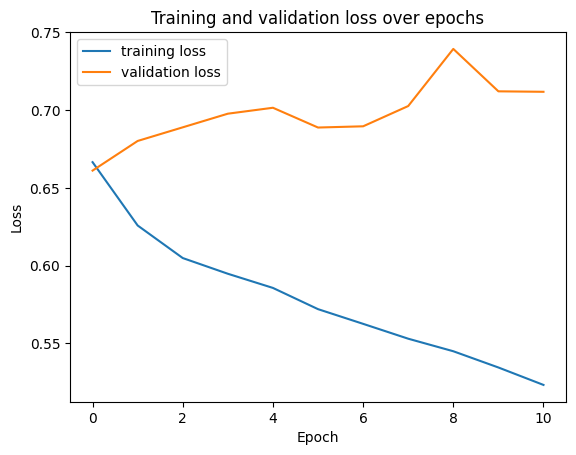

In [ ]:
#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()

In [21]:
import tensorflow as tf

In [51]:
# we first define a function that will be a scheduler and will permit to our learning rate to decrease over epochs
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [23]:
# we now implement our optimizer, chosen in the gridsearch part
from keras.optimizers import Adam

In [24]:
from keras.callbacks import LearningRateScheduler

In [25]:
gridsearch = {
    "batch" : [32, 64, 128],
    "dropout" : [0.3],
    "optimizer" : ["adam", "adagrad"],
}

In [388]:
def train_evaluate_lstm(params, X_train, X_val, y_train, y_val): 
        """Function that trains an lstm model given a list of params, a training set and 
        a validation set with their respective labels. It returns the mean of the validation
        accuracy."""

        initial_lr = 0.001  # the default starting learning rate for Adam and Adagrad
 
        patience = 10  

        # the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
        lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

        threshold = 0.5

        model = Sequential()
        model.add(LSTM(100, dropout= 0.3, return_sequences=True, recurrent_dropout= 0.3, input_shape = (max_len, emb_len), activation="relu"))
        model.add(Dropout(0.3))
        model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, activation="relu"))
        model.add(Dropout(0.3))
        model.add(Dense(4, activation='sigmoid'))

        # compile the model
        model.compile(loss='binary_crossentropy', optimizer=params["optimizer"], metrics=['accuracy'])

        history = model.fit(X_train, y_train,
                epochs=50,
                validation_data=(X_val, y_val),
                batch_size=params["batch"],
                verbose=1,
                callbacks=[early_stopping, lr_scheduler])

        y_pred_probs = model.predict(X_val)

        # convert probabilities to binary predictions
        y_pred_binary = (y_pred_probs > threshold).astype(int)

        # print classification report
        print("Parameters:", params)
        print(classification_report(y_val, y_pred_binary))

        # calculate and return accuracy or other primary metric
        accuracy = accuracy_score(y_val, y_pred_binary)
        return accuracy

In [389]:
from itertools import product
from tqdm import tqdm

best_score = 0
best_params = None

# Create all combinations of parameters
param_combinations = [dict(zip(gridsearch.keys(), v)) for v in product(*gridsearch.values())]
for params in tqdm(param_combinations):
    score = train_evaluate_lstm(params, X_train, X_val, y_train, y_val)
    if score > best_score:
        best_score = score
        best_params = params

print("Best Score:", best_score)
print("Best Parameters:", best_params)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/50
87/87 [==============================] - 40s 419ms/step - loss: 0.6389 - accuracy: 0.2509 - val_loss: 0.6784 - val_accuracy: 0.2684 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 31s 360ms/step - loss: 0.5999 - accuracy: 0.4108 - val_loss: 0.6856 - val_accuracy: 0.1624 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 31s 357ms/step - loss: 0.5845 - accuracy: 0.4671 - val_loss: 0.7064 - val_accuracy: 0.1885 - lr: 0.0010
Epoch 4/50
87/87 [==============================] - 31s 358ms/step - loss: 0.5691 - accuracy: 0.4610 - val_loss: 0.7106 - val_accuracy: 0.1732 - lr: 0.0010
Epoch 5/50
87/87 [==============================] - 31s 357ms/step - loss: 0.5598 - accuracy: 0.4747 - val_loss: 0.7120 - val_accuracy: 0.1732 - lr: 0.0010
Epoch 6/50
87/87 [==============================] - 31s 355ms/step - loss: 0.5393 - accuracy: 0.4726 - val_loss: 0.7260 - val_accuracy: 0.1751 - lr: 0.0010
Epoch 7/50
87/87 [==============================] - 31s 355ms/st

 17%|█▋        | 1/6 [05:58<29:54, 358.95s/it]

Parameters: {'batch': 32, 'dropout': 0.3, 'optimizer': 'adam'}
              precision    recall  f1-score   support

           0       0.37      0.43      0.40       614
           1       0.42      0.93      0.58       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.61      0.89      0.73      3659
   macro avg       0.58      0.84      0.67      3659
weighted avg       0.63      0.89      0.73      3659
 samples avg       0.62      0.90      0.71      3659

Epoch 1/50
87/87 [==============================] - 36s 375ms/step - loss: 0.6998 - accuracy: 0.2755 - val_loss: 0.6931 - val_accuracy: 0.2278 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 30s 346ms/step - loss: 0.6974 - accuracy: 0.2664 - val_loss: 0.6910 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 30s 348ms/step - loss: 0.6945 - accuracy: 0.2628 - val_loss: 0.6892 - val_accuracy: 

 33%|███▎      | 2/6 [31:37<1:10:11, 1052.76s/it]

Parameters: {'batch': 32, 'dropout': 0.3, 'optimizer': 'adagrad'}
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       614
           1       0.42      1.00      0.59       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.58      1.00      0.73      3659
   macro avg       0.58      1.00      0.72      3659
weighted avg       0.63      1.00      0.76      3659
 samples avg       0.58      1.00      0.71      3659

Epoch 1/50
44/44 [==============================] - 42s 873ms/step - loss: 0.6760 - accuracy: 0.1560 - val_loss: 0.6723 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 39s 894ms/step - loss: 0.6488 - accuracy: 0.1097 - val_loss: 0.6685 - val_accuracy: 0.2367 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 39s 892ms/step - loss: 0.6454 - accuracy: 0.1069 - val_loss: 0.6663 - val_accurac

 50%|█████     | 3/6 [44:11<45:48, 916.21s/it]   

Epoch 1/50
44/44 [==============================] - 44s 925ms/step - loss: 0.6858 - accuracy: 0.3155 - val_loss: 0.6931 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 43s 984ms/step - loss: 0.6847 - accuracy: 0.3116 - val_loss: 0.6923 - val_accuracy: 0.2963 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 43s 989ms/step - loss: 0.6823 - accuracy: 0.3191 - val_loss: 0.6916 - val_accuracy: 0.2906 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 43s 990ms/step - loss: 0.6828 - accuracy: 0.3173 - val_loss: 0.6909 - val_accuracy: 0.2881 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 43s 990ms/step - loss: 0.6815 - accuracy: 0.3051 - val_loss: 0.6902 - val_accuracy: 0.2849 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 44s 996ms/step - loss: 0.6805 - accuracy: 0.3022 - val_loss: 0.6896 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 44s 992ms/st

 67%|██████▋   | 4/6 [1:20:35<47:13, 1416.94s/it]

Parameters: {'batch': 64, 'dropout': 0.3, 'optimizer': 'adagrad'}
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       614
           1       0.42      1.00      0.59       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.58      1.00      0.73      3659
   macro avg       0.58      1.00      0.72      3659
weighted avg       0.63      1.00      0.76      3659
 samples avg       0.58      1.00      0.71      3659

Epoch 1/50
22/22 [==============================] - 56s 2s/step - loss: 0.6542 - accuracy: 0.1422 - val_loss: 0.6682 - val_accuracy: 0.1929 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 53s 2s/step - loss: 0.6187 - accuracy: 0.2892 - val_loss: 0.6783 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 52s 2s/step - loss: 0.6500 - accuracy: 0.3321 - val_loss: 0.6802 - val_accuracy: 0.1796

 83%|████████▎ | 5/6 [1:30:24<18:38, 1118.20s/it]

Parameters: {'batch': 128, 'dropout': 0.3, 'optimizer': 'adam'}
              precision    recall  f1-score   support

           0       0.38      0.81      0.52       614
           1       0.42      0.92      0.57       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.59      0.95      0.73      3659
   macro avg       0.58      0.93      0.70      3659
weighted avg       0.63      0.95      0.75      3659
 samples avg       0.59      0.96      0.71      3659

Epoch 1/50
22/22 [==============================] - 55s 2s/step - loss: 0.6967 - accuracy: 0.3271 - val_loss: 0.6993 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 51s 2s/step - loss: 0.6961 - accuracy: 0.3253 - val_loss: 0.6988 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 51s 2s/step - loss: 0.6954 - accuracy: 0.3256 - val_loss: 0.6983 - val_accuracy: 0.3401 -

100%|██████████| 6/6 [2:13:31<00:00, 1335.31s/it]

 {'batch': 128, 'dropout': 0.3, 'optimizer': 'adagrad'}
              precision    recall  f1-score   support

           0       0.39      0.99      0.56       614
           1       0.42      0.99      0.59       660
           2       0.75      1.00      0.86      1181
           3       0.76      0.94      0.84      1204

   micro avg       0.58      0.98      0.73      3659
   macro avg       0.58      0.98      0.71      3659
weighted avg       0.63      0.98      0.75      3659
 samples avg       0.58      0.98      0.70      3659

Best Score: 0.11230964467005077
Best Parameters: {'batch': 32, 'dropout': 0.3, 'optimizer': 'adam'}


In [407]:
# judging by the classification report we chose the parameters that seemed to give us the best model based on the mean f1-score

best_params = {'batch': 64, 'dropout': 0.3, 'optimizer': 'adam'}

initial_lr = 0.001  # the default starting learning rate for Adam

patience = 10  

# the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

threshold = 0.5

model = Sequential()
model.add(LSTM(100, dropout=best_params["dropout"], return_sequences=True, recurrent_dropout= best_params["dropout"], input_shape = (max_len, emb_len), activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(LSTM(50, dropout=best_params["dropout"], recurrent_dropout=best_params["dropout"], activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=best_params["optimizer"], metrics=['accuracy'])

history = model.fit(X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        batch_size=best_params["batch"],
        verbose=1,
        callbacks=[early_stopping, lr_scheduler])

y_pred_probs = model.predict(X_val)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Print classification report
print(classification_report(y_val, y_pred_binary))


Epoch 1/50
44/44 [==============================] - 65s 1s/step - loss: 0.6463 - accuracy: 0.1823 - val_loss: 0.6688 - val_accuracy: 0.2011 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 62s 1s/step - loss: 0.6187 - accuracy: 0.3711 - val_loss: 0.6767 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 69s 2s/step - loss: 0.6013 - accuracy: 0.3845 - val_loss: 0.6703 - val_accuracy: 0.1624 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 66s 1s/step - loss: 0.5915 - accuracy: 0.3978 - val_loss: 0.6819 - val_accuracy: 0.1802 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 70s 2s/step - loss: 0.5818 - accuracy: 0.4390 - val_loss: 0.6855 - val_accuracy: 0.1675 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 65s 1s/step - loss: 0.5726 - accuracy: 0.4354 - val_loss: 0.7077 - val_accuracy: 0.1681 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 64s 1s/step - loss: 0.5598 - a

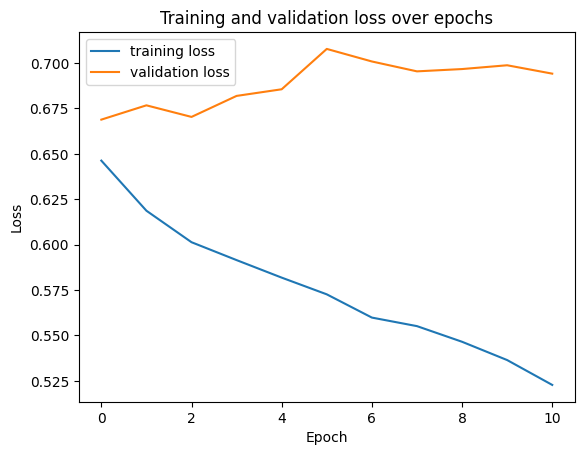

In [409]:
#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()

Epoch 1/50
44/44 [==============================] - 81s 2s/step - loss: 0.6919 - accuracy: 0.2029 - val_loss: 0.6810 - val_accuracy: 0.1326 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 41s 940ms/step - loss: 0.6619 - accuracy: 0.1823 - val_loss: 0.6785 - val_accuracy: 0.1282 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 41s 942ms/step - loss: 0.6621 - accuracy: 0.1238 - val_loss: 0.6763 - val_accuracy: 0.2430 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 41s 945ms/step - loss: 0.6600 - accuracy: 0.1307 - val_loss: 0.6756 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 42s 966ms/step - loss: 0.6543 - accuracy: 0.1170 - val_loss: 0.6744 - val_accuracy: 0.2716 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 46s 1s/step - loss: 0.6528 - accuracy: 0.1051 - val_loss: 0.6730 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 46s 1s/step - loss

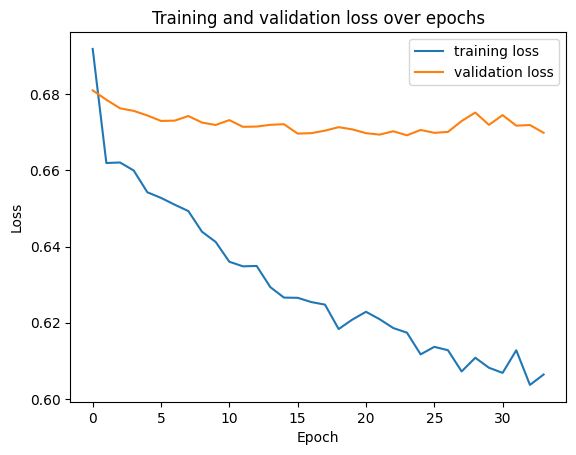

In [414]:
# hoping to reduce overfitting we decided to increase the dropout rate at 0.7
# judging by the classification report we chose the parameters that seemed to give us the best model based on the mean f1-score

best_params = {'batch': 64, 'dropout': 0.7, 'optimizer': 'adam'}

initial_lr = 0.001  # the default starting learning rate for Adam

patience = 10  

# the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

threshold = 0.6

model = Sequential()
model.add(LSTM(100, dropout=best_params["dropout"], return_sequences=True, recurrent_dropout= best_params["dropout"], input_shape = (max_len, emb_len), activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(LSTM(50, dropout=best_params["dropout"], recurrent_dropout=best_params["dropout"], activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=best_params["optimizer"], metrics=['accuracy'])

history = model.fit(X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        batch_size=best_params["batch"],
        verbose=1,
        callbacks=[early_stopping, lr_scheduler])

y_pred_probs = model.predict(X_val)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Print classification report
print(classification_report(y_val, y_pred_binary))

#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()


In [471]:
y_pred_probs

array([[0.5215948 , 0.6090773 , 0.60697854, 0.63256   ],
       [0.55124   , 0.56883025, 0.5875583 , 0.61892146],
       [0.5401921 , 0.57526577, 0.5845827 , 0.6174972 ],
       ...,
       [0.4901238 , 0.6743161 , 0.65440613, 0.6650407 ],
       [0.5110638 , 0.65876114, 0.6406957 , 0.6532417 ],
       [0.5265207 , 0.59945196, 0.59648466, 0.62787545]], dtype=float32)

We will now try to implement embedding layer to make the word2vec vectors trainable and see if it improves out performance

In [139]:
%store -r w2v_model
# from word2vec.ipynb

In [140]:
%store -r df
# from undersampling.ipynb, it's the dataframe with the IDs of the arguments mantained after undersampling

In [141]:
import pandas as pd

In [142]:
df_train = pd.read_csv("arguments-training.tsv", sep = "\t")
df_train.head()

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [143]:
df

,Argument_ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333..."
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666..."
...,...,...,...,...,...,...
5383,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]"
5384,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ..."
5385,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
5387,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]"


In [144]:
df.rename(columns={"Argument ID": "Argument_ID"}, inplace=True)
df_train.rename(columns={"Argument ID": "Argument_ID"}, inplace=True)

In [145]:
# we merge the training dataframe and the df after the undersampling 
merged_df_train = pd.merge(df, df_train, on='Argument_ID', how='inner')
merged_df_train

,Argument_ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels,Conclusion,Stance,Premise
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]",We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]",We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]",We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333...",We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666...",We should ban factory farming,against,factory farming allows for the production of c...
...,...,...,...,...,...,...,...,...,...
2765,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]",The EU should integrate the armed forces of it...,in favor of,Absolutely right. Europe needs an army for con...
2766,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ...",The EU should integrate the armed forces of it...,in favor of,"In principle, I would be in favor of a Europea..."
2767,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]",The EU should integrate the armed forces of it...,in favor of,I agree with your idea. But it is a long and a...
2768,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]",The EU should integrate the armed forces of it...,in favor of,"On the one hand, we have Russia killing countl..."


In [146]:
import spacy

In [147]:
# we now preprocess the text in the premise
# load the English language model
nlp = spacy.load("en_core_web_sm")

In [148]:
def preprocess_text(text):
    doc = nlp(text)
    # set lowercase
    processed_text = [token.text.lower()for token in doc]
    return processed_text

In [149]:
merged_df_train["premise_tokenized"] = merged_df_train["Premise"].apply(preprocess_text)

In [150]:
train_corpus = merged_df_train["premise_tokenized"].tolist()

In [151]:
from keras.preprocessing.text import Tokenizer

In [152]:
import nltk
from nltk.corpus import stopwords


In [153]:
stop_words = set(stopwords.words('english'))

In [154]:
# we selected from the most frequent words those that seemed to too frequent (people) or less informative (would, n't, many and 's)
most_freq_words = ["people", "would", "'n't", "many", "'s"]
custom_stop_words = list(stop_words)
custom_stop_words.append("people")
custom_stop_words = set(custom_stop_words)

In [155]:

# we now need to modify the validation and test inputs so that they are a list of integers that can be fed to an Embedding layer. 
# We first create the test and validation corpus
val_df = pd.read_csv("arguments-validation.tsv", sep = "\t")
val_df = val_df.iloc[:1576]
val_df["premise_tokenized"] = val_df["Premise"].apply(preprocess_text)
val_corpus = val_df["premise_tokenized"].tolist()

test_df = pd.read_csv("arguments-test.tsv", sep = "\t")
test_df["premise_tokenized"] = test_df["Premise"].apply(preprocess_text)
test_corpus = test_df["premise_tokenized"].tolist()

In [156]:
# Modifying the train, validation and test corpus, excluding stop_words
train_corpus = [[token for token in doc if token not in custom_stop_words] for doc in train_corpus]
# remove numbers, but not words that contain numbers.
train_corpus = [[token for token in doc if not token.isnumeric()] for doc in train_corpus]
# remove words that are only one character.
train_corpus = [[token for token in doc if len(token) > 1] for doc in train_corpus]

val_corpus = [[token for token in doc if token not in custom_stop_words] for doc in val_corpus]
val_corpus = [[token for token in doc if not token.isnumeric()] for doc in val_corpus]
val_corpus = [[token for token in doc if len(token) > 1] for doc in val_corpus]

test_corpus = [[token for token in doc if token not in custom_stop_words] for doc in test_corpus]
test_corpus = [[token for token in doc if not token.isnumeric()] for doc in test_corpus]
test_corpus = [[token for token in doc if len(token) > 1] for doc in test_corpus]

In [157]:
# we now create a dictionary that has for keys the words in out dictionary and for values thei integer indices
t = Tokenizer()
t.fit_on_texts(train_corpus)
train_w2id = t.word_index 

In [158]:
# we now create and embedding matrix with same number of rows as the size of the vocabulary and same number of columns as the w2v features
vocab_size = len(train_w2id) + 1

embedding_matrix = np.zeros((vocab_size, emb_len))

for word, i in train_w2id.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

embedding_matrix.shape

(5364, 150)

In [159]:
# Now we tranform the corpus in a list of integers representing the words for each document
X_train_seq = t.texts_to_sequences(train_corpus)
X_val_seq = t.texts_to_sequences(val_corpus)
X_test_seq = t.texts_to_sequences(test_corpus)

In [160]:
# padding the sequences
X_train_seq = pad_sequences(X_train_seq, max_len)
X_val_seq = pad_sequences(X_val_seq, max_len)
X_test_seq = pad_sequences(X_test_seq, max_len)

In [161]:
emb_layer = Embedding(input_dim=vocab_size, output_dim=emb_len, weights = [embedding_matrix], input_length = max_len, trainable = True)

In [165]:
lstm_emb = Sequential()


lstm_emb.add(emb_layer)
lstm_emb.add(LSTM(100, activation="relu", dropout=0.2, input_shape = (max_len, emb_len), return_sequences=True))
lstm_emb.add(Dropout(0.3))
lstm_emb.add(LSTM(50, activation="relu", dropout=0.2))
lstm_emb.add(Dropout(0.3))
lstm_emb.add(Dense(4, activation="sigmoid"))

lstm_emb.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [166]:
history = lstm_emb.fit(X_train_seq, y_train,
        epochs=5,
        validation_data=(X_val_seq, y_val),
        batch_size=64,
        verbose=1)



Epoch 1/5
44/44 [==============================] - 10s 173ms/step - loss: 0.6144 - accuracy: 0.2581 - val_loss: 0.6472 - val_accuracy: 0.3395
Epoch 2/5
44/44 [==============================] - 7s 167ms/step - loss: 0.5598 - accuracy: 0.4650 - val_loss: 0.6392 - val_accuracy: 0.2900
Epoch 3/5
44/44 [==============================] - 8s 184ms/step - loss: 0.5566 - accuracy: 0.4881 - val_loss: 0.6363 - val_accuracy: 0.3052
Epoch 4/5
44/44 [==============================] - 8s 174ms/step - loss: 0.5161 - accuracy: 0.5065 - val_loss: 0.6460 - val_accuracy: 0.3706
Epoch 5/5
44/44 [==============================] - 7s 164ms/step - loss: 0.4871 - accuracy: 0.5260 - val_loss: 0.6385 - val_accuracy: 0.3312


In [167]:
threshold = 0.5
y_pred_probs = lstm_emb.predict(X_val_seq)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Print classification report
print(classification_report(y_val, y_pred_binary))

50/50 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       614
           1       0.51      0.83      0.63       660
           2       0.78      0.85      0.81      1181
           3       0.77      0.94      0.85      1204

   micro avg       0.66      0.85      0.75      3659
   macro avg       0.64      0.83      0.72      3659
weighted avg       0.68      0.85      0.75      3659
 samples avg       0.68      0.86      0.72      3659



In [96]:
y_val

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 1],
       ...,
       [1, 0, 1, 1],
       [0, 0, 1, 1],
       [1, 1, 1, 1]])

In [168]:
y_pred_probs

array([[0.36733866, 0.57474875, 0.61256826, 0.6799597 ],
       [0.24098738, 0.8706058 , 0.80069584, 0.6935707 ],
       [0.3276463 , 0.6352622 , 0.77044106, 0.78641385],
       ...,
       [0.58401424, 0.5954576 , 0.7766377 , 0.7667901 ],
       [0.56489366, 0.5144022 , 0.934897  , 0.7893493 ],
       [0.68643403, 0.65925103, 0.68188304, 0.7134536 ]], dtype=float32)

Given that the performance doesn't seem to improve with the embedding layer but at least the model is not always predicting the same values, we try the test set in both the models

In [172]:
%store -r y_test

In [173]:
threshold = 0.5
y_pred_probs = lstm_emb.predict(X_test_seq)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_binary))

50/50 [==============================] - 2s 35ms/step
              precision    recall  f1-score   support

           0       0.39      0.66      0.49       474
           1       0.47      0.79      0.59       628
           2       0.71      0.91      0.80      1082
           3       0.81      0.96      0.88      1254

   micro avg       0.64      0.87      0.74      3438
   macro avg       0.60      0.83      0.69      3438
weighted avg       0.66      0.87      0.75      3438
 samples avg       0.65      0.88      0.72      3438



In [174]:
y_pred_probs

array([[0.46003476, 0.7245192 , 0.60689986, 0.5432678 ],
       [0.5148615 , 0.52956253, 0.53116006, 0.5756316 ],
       [0.25479624, 0.50729334, 0.75395226, 0.88303185],
       ...,
       [0.13885248, 0.9744267 , 0.92457515, 0.6660351 ],
       [0.2772943 , 0.93334013, 0.6731743 , 0.5776182 ],
       [0.50797075, 0.6108488 , 0.62459415, 0.58427715]], dtype=float32)